Reverse the z score normalisation of the nanopore pore models. HAs user tunable STD_DEV and MEAN values - which creates a current value for each kmer in the 9mer_levels_v1.txt file. Then creates squiggle from the reads found in testing_r10_fasta.fasta in the fasta directory, starts a guppy server instance and basecalles them, Then maps them to the chromsome 20 sequence in the fasta directory.

In [8]:
import collections
import re
import time as t
from contextlib import contextmanager, redirect_stdout
from datetime import datetime
from io import StringIO
from itertools import islice
from pathlib import Path
from typing import Union

import mappy as mp
import numpy as np
import numpy.typing as npt
import pandas as pd
# from pyfastx import Fasta
from mappy import fastx_read
from random import sample, gauss
from pyguppy_client_lib import helper_functions
from pyguppy_client_lib.pyclient import PyGuppyClient

MEAN = 98
STD_DEV = 23
BIN_PATH = "/usr/bin/"
FORMAT = "%d%m%y%H%M%S"
DIGITISATION = 8192
RANGE = 1350
SAMPLES = (9,10)

PREFIX = (
    "TTTTTTTTTTTTTTTTTTAATCAAGCAGCGGAGTTGAGGACGCGAGACGGGACTTTTTTAGCAGACTTTACGGACTACGACT"
)
df = pd.read_csv("9mer_levels_v1.txt", header=None, sep="\t", names=["kmer", "value"])


def pack(read: dict[str : Union[str, npt.NDArray[np.int16]]]):
    """Pack an ont_fast5_api.Fast5Read for calling
    passed dict has two fields, read_id and raw_Data
    read_id: str, raw_data: npt.NDArray[np.int16]
    """
    read_id = read["read_id"]
    raw_data = read["raw_data"]
    scaling = RANGE / DIGITISATION
    offset = 0.0
    return helper_functions.package_read(read_id, raw_data, offset, scaling)


@contextmanager
def start_guppy_server_and_client(bin_path, config, port, server_args):
    # server_args.extend(
    #     ["--config", config, "--port", port, "--log_path", str((Path(".") / "junk"))]
    # )
    # # This function has it's own prints that may want to be suppressed
    # with redirect_stdout(StringIO()) as fh:
    #     server, port = helper_functions.run_server(server_args, bin_path=bin_path)

    # if port == "ERROR":
    #     raise RuntimeError("Server couldn't be started")

    if port.startswith("ipc"):
        address = f"{port}"
    # else:
    #     address = f"localhost:{port}"
    client = PyGuppyClient(address=address, config=config)

    try:
        with client:
            yield client
    finally:
        # server.terminate()
        pass


def sliding_window(iterable, n):
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)

def expandy(arr, n):
    """
    This is a super slow function that we need to run in some other way to make it more efficient.
    :param arr:
    :param n:
    :return:
    """
    return np.random.laplace(arr, n, arr.shape[0])


def signalify(
    kmers: dict[str, dict[str, float]], sequence: str, noise: bool = False
) -> npt.NDArray[np.int16]:
    """convert a given sequence to signal using R10 models,
    returning np array containing 10 samples per base"""
    a = []
    # Always upper case signal
    for kmer in sliding_window(sequence.upper(), 9):
        value = kmers["".join(kmer)]["new_value"]
        # value = (value * 2048) / 300 - 57
        for _ in range(sample(SAMPLES,1)[0]):
        # for _ in range(10):
            a.append(value)
    if noise:
        a = expandy(np.array(a).astype(np.int16), 1/np.sqrt(2))
    return a.astype(np.int16)


def calculate_identity(cigar: str, goal_length: int):
    match = re.findall(r"(\d+)([MIDNSHP=X])", cigar)

    # Calculate total matches, mismatches, and alignment length
    total_matches = sum(int(length) for length, operation in match if operation == "M")
    alignment_length = sum(
        int(length) for length, operation in match if operation in ["M", "D", "I", "N"]
    )
    total_insertions = sum(
        int(length) for length, operation in match if operation == "I"
    )

    # Calculate total query length (alignment length + insertions)
    total_query_length = goal_length + total_insertions

    # Identity is calculated as the number of matches divided by total query length
    identity = total_matches / total_query_length if total_query_length > 0 else 0
    return identity


mean_identities = []
fa = {name: seq for name, seq, _ in fastx_read("../fasta/identity_fasta.fasta")}
with start_guppy_server_and_client(
            BIN_PATH,
            "dna_r10.4.1_e8.2_400bps_fast.cfg",
            "ipc:///tmp/.guppy/5555",
            ["--device", "cuda:all"],
        ) as client:
    # for MEAN in np.linspace(95, 105, 20, endpoint=False):
    #     for STD_DEV in np.linspace(12, 30, 90, endpoint=False):
    MEAN =95
    STD_DEV = 21
    print(f"Checking MEAN: {MEAN}, STD_DEV: {STD_DEV}")
    time = datetime.now().strftime(FORMAT)
    work_dir = Path("working") / time
    work_dir.mkdir(exist_ok=True, parents=False)
    df["new_value"] = df["value"] * STD_DEV + MEAN - 10

    kmer_values = df.set_index("kmer").to_dict(orient="index")

    df.to_csv(f"good_model.tsv", sep="\t", index=None, header=None)

    prefix = signalify(kmer_values, PREFIX, noise=True)



    for name, seq in fa.items():
        # remove any non ACGT and replace with A
        # sequence = re.sub(r"[^ACGT]", "A", seq.seq, flags=re.IGNORECASE)
        signal = signalify(kmer_values, seq, noise=True)
        # print(signal)
        signal = np.concatenate((prefix, signal))
        read = {"read_id": name, "raw_data": signal}
        success_pass = client.pass_read(read, pack)
    t.sleep(7)
    res = client.get_completed_reads()
    print(
        f"Number of reads base called: {len(res)} for Mean: {MEAN}, std dev {STD_DEV}"
    )
    identities = []
    al_count = 0
    for r in res:
        # print(r[0]["datasets"].get("sequence", ""))
        read_id = r[0]["metadata"]["read_id"]
        reference_fasta = fa[read_id]
        aligner = mp.Aligner(seq=str(reference_fasta), preset="map-ont")
        # print(bool(aligner))
        start, end = r[0]["metadata"]["read_id"].rsplit("_", 2)[-2:]
        read_number = r[0]["metadata"]["read_id"].rsplit("_", 3)[-3]
        sequence = r[0]["datasets"].get("sequence", "")
        als = aligner.map(sequence)
        for al in als:
            identity = calculate_identity(al.cigar_str, al.ctg_len)
            identities.append(identity)
            al_count += 1
    print(
        f"Number of reads aligned: {al_count} for Mean: {MEAN}, std dev {STD_DEV}\n"
    )
    if identities:
        m_id = np.mean(identities)
        mean_identities.append((m_id, MEAN, STD_DEV))
        print(m_id)
print(sorted(mean_identities, key=lambda x: x[0], reverse=True))

Checking MEAN: 95, STD_DEV: 21
Number of reads base called: 20 for Mean: 95, std dev 21
Number of reads aligned: 16 for Mean: 95, std dev 21

0.9075160063811893
[(0.9075160063811893, 95, 21)]


[Text(0, 0.5, '')]

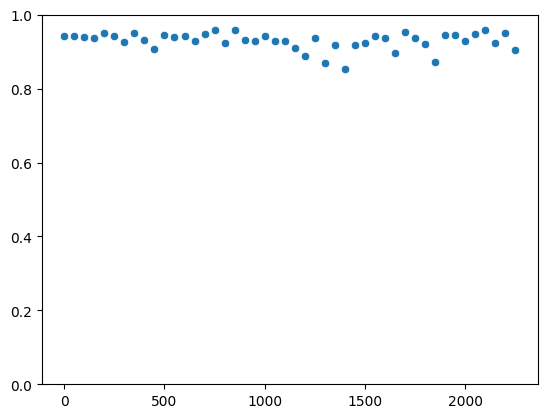

In [7]:
import seaborn as sns
ax = sns.scatterplot(
    x=list(np.arange(len(identities))*50),
    y=list(identities),
)
ax.set_ylim((0, 1))
ax.set(ylabel="")

In [ ]:
105/30 # mean and std_dev

0.9313414817836391
Checking MEAN: 102.0, STD_DEV: 27.0


Checking MEAN: 102.5, STD_DEV: 22.0
Number of reads base called: 50 for Mean: 102.5, std dev 22.0
Number of reads aligned: 46 for Mean: 102.5, std dev 22.0

0.9330289731239149